In [2]:
import sys  
import time  
import math  
import uuid  
import numpy as np  
import matplotlib.pyplot as plt
import pickle
import plotly.graph_objs as go
from numpy import errstate  
from sklearn.datasets import fetch_openml  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder  
from tqdm import tqdm

In [3]:
sys.setrecursionlimit(10000)

In [4]:
from varValue import VarValue
from layer import Layer
from ffnn import FFNN

In [5]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=65500,
    train_size=10,
    random_state=42,
    stratify=y
)

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
X_train = np.array([[VarValue(x, varname='x_'+str(uuid.uuid4())) for x in row] for row in X_train])

In [9]:
model_ffnn = FFNN(
    loss='cce',
    batch_size=1,
    learning_rate=0.1,
    epochs=2,
    verbose=1,
)

In [10]:
model_ffnn.build_layers(
    Layer(n_neurons=4, init='uniform', activation='relu'),
    Layer(n_neurons=3, init='uniform', activation='relu'),
    Layer(n_neurons=2, init='uniform', activation='relu'),
    Layer(n_neurons=10, init='uniform', activation='softmax')
)

In [11]:
history = model_ffnn.fit(X_train, y_train)

Training Progress:  50%|█████     | 1/2 [00:07<00:07,  7.84s/epoch]

Epoch 1/2, Train Loss: 2.4251


Training Progress: 100%|██████████| 2/2 [00:14<00:00,  7.17s/epoch]

Epoch 2/2, Train Loss: 2.4233
Total Duration: 14.363247871398926


In [12]:
model_ffnn.visualize()

In [13]:
for layer in model_ffnn.layers:
    print("=====Layer======")
    for i in range(len(layer.weights)):
        print("==Neuron==")
        for j in range(len(layer.weights[0])):
            print(f"[{i}][{j}]{layer.weights[i][j].value}")

=====Layer======
==Neuron==
[0][0]-0.0189
[0][1]0.0067
[0][2]0.019
[0][3]0.0025
==Neuron==
[1][0]-0.0046
[1][1]-0.0166
[1][2]0.0175
[1][3]-0.0034
==Neuron==
[2][0]0.0274
[2][1]0.0062
[2][2]-0.0165
[2][3]-0.0191
==Neuron==
[3][0]0.0179
[3][1]-0.0279
[3][2]0.0294
[3][3]0.0201
==Neuron==
[4][0]0.034
[4][1]0.0288
[4][2]0.0222
[4][3]0.0165
==Neuron==
[5][0]0.0189
[5][1]-0.0086
[5][2]-0.0038
[5][3]0.0281
==Neuron==
[6][0]0.0126
[6][1]0.0286
[6][2]-0.025
[6][3]0.006
==Neuron==
[7][0]-0.0332
[7][1]0.0073
[7][2]-0.0353
[7][3]0.016
==Neuron==
[8][0]-0.0205
[8][1]0.003
[8][2]-0.0014
[8][3]-0.034
==Neuron==
[9][0]-0.0237
[9][1]0.026
[9][2]0.0264
[9][3]0.0112
==Neuron==
[10][0]0.0114
[10][1]0.0007
[10][2]-0.0353
[10][3]0.033
==Neuron==
[11][0]0.0182
[11][1]-0.0131
[11][2]-0.0081
[11][3]0.0101
==Neuron==
[12][0]-0.0212
[12][1]-0.011
[12][2]0.0014
[12][3]-0.0264
==Neuron==
[13][0]-0.0316
[13][1]0.0338
[13][2]0.021
[13][3]-0.0283
==Neuron==
[14][0]0.004
[14][1]-0.0218
[14][2]0.0145
[14][3]0.0276
==Neu

In [14]:
for layer in model_ffnn.layers:
    for i in layer.weights:
        for j in i:
            print(j.value)

-0.0189
0.0067
0.019
0.0025
-0.0046
-0.0166
0.0175
-0.0034
0.0274
0.0062
-0.0165
-0.0191
0.0179
-0.0279
0.0294
0.0201
0.034
0.0288
0.0222
0.0165
0.0189
-0.0086
-0.0038
0.0281
0.0126
0.0286
-0.025
0.006
-0.0332
0.0073
-0.0353
0.016
-0.0205
0.003
-0.0014
-0.034
-0.0237
0.026
0.0264
0.0112
0.0114
0.0007
-0.0353
0.033
0.0182
-0.0131
-0.0081
0.0101
-0.0212
-0.011
0.0014
-0.0264
-0.0316
0.0338
0.021
-0.0283
0.004
-0.0218
0.0145
0.0276
-0.0265
0.0108
-0.0268
-0.0228
0.016
-0.0095
0.0039
0.01
-0.0115
-0.0235
-0.0048
-0.0225
0.035
0.0322
0.0042
0.0337
-0.0016
0.0032
0.0206
-0.0226
-0.0261
-0.0319
0.0009
-0.0212
-0.0197
0.0114
0.0242
0.0277
0.0248
0.0179
0.0163
-0.0099
0.0309
-0.0176
0.0341
-0.011
0.0318
-0.0174
-0.0063
-0.0354
-0.0073
-0.0084
-0.0302
0.0322
-0.0355
-0.0115
0.0093
0.0287
0.0305
0.0288
0.0139
0.0089
-0.0062
-0.0326
0.0104
0.0102
0.035
-0.0071
-0.0226
0.035
-0.0077
0.0311
-0.0032
0.013
-0.0325
-0.0124
-0.0136
0.005
-0.0059
0.0048
0.0158
-0.0013
0.0024
-0.0231
0.0196
0.0278
0.0157


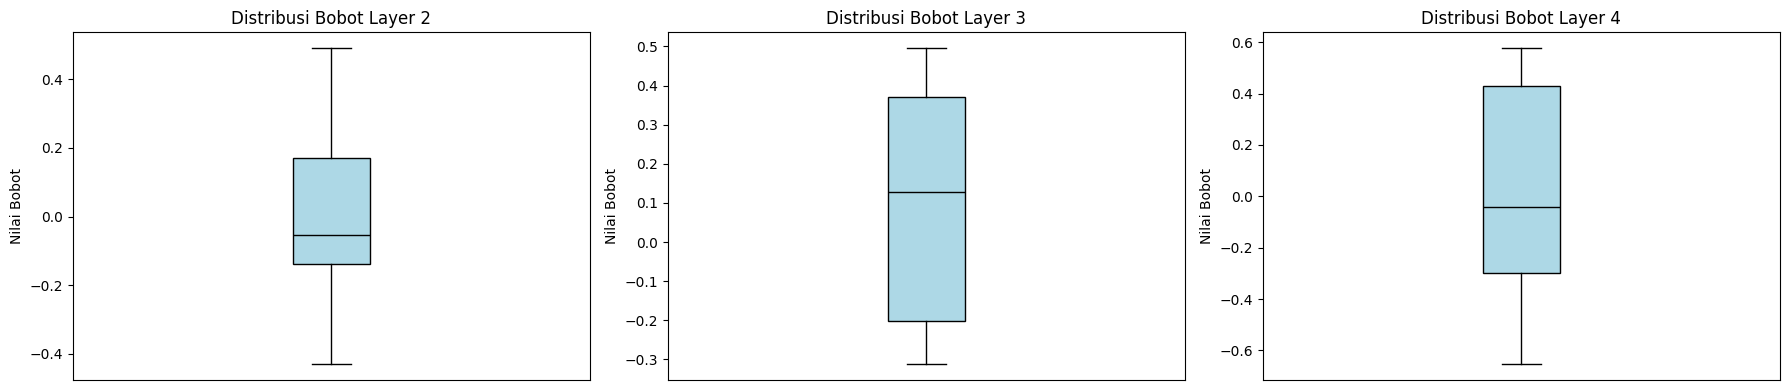

In [15]:
model_ffnn.plot_weights_distribution(layers_to_plot=[1,2,3])

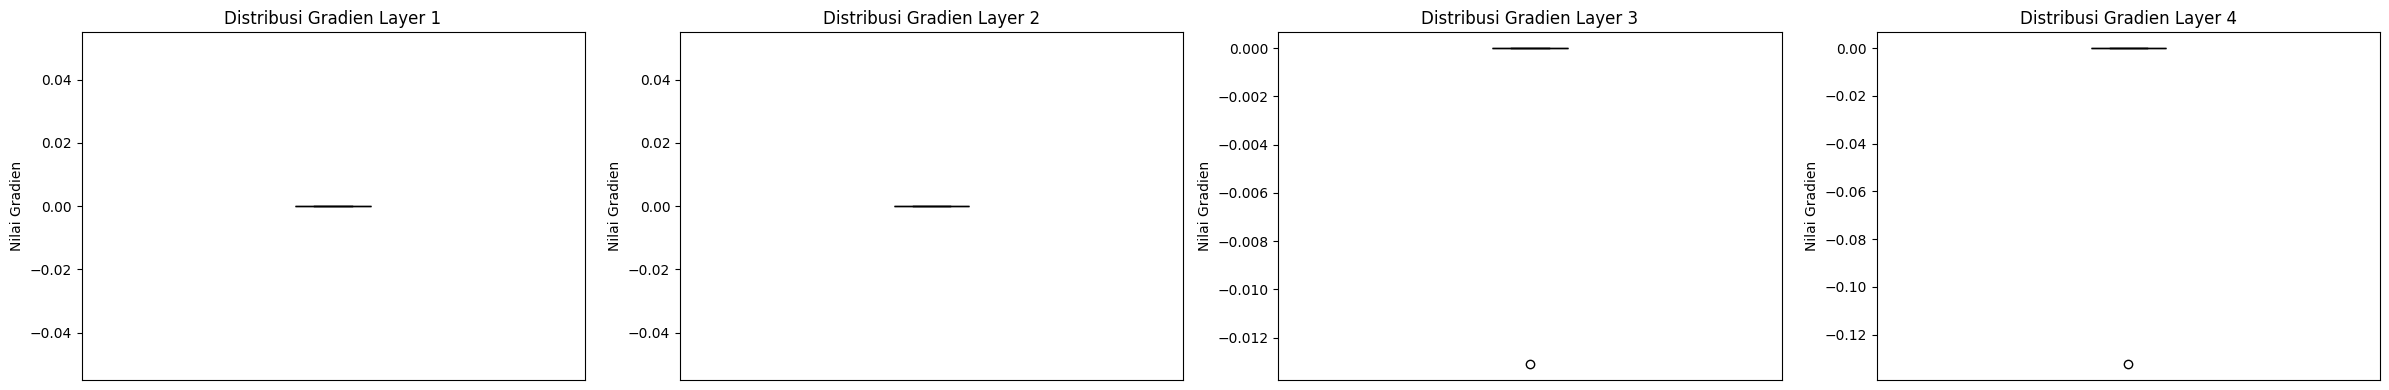

In [16]:
model_ffnn.plot_gradients_distribution(layers_to_plot=[0, 1, 2, 3])

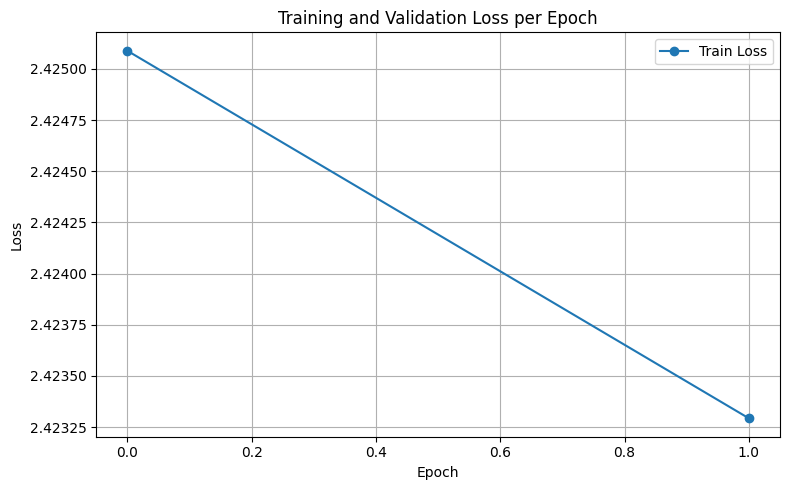

In [17]:
model_ffnn.plot_loss_history(history)

In [18]:
y_pred = model_ffnn.predict(X_test[:10])
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

0
0
0
0
0
0
0
0
0
0


In [19]:
model_ffnn.y.shape

(10, 10)

In [20]:
for h in y_test[:10].flatten():
    print(h)

9
6
5
9
6
9
8
8
1
2


In [21]:
model_ffnn.save(filename="try1.pth")

Model saved to try1.pth


In [22]:
new_model = FFNN()
new_model.load(filename="try1.pth")

Model loaded from try1.pth


In [23]:
y_pred = new_model.predict(X_test[:10])
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

0
0
0
0
0
0
0
0
0
0
